# 1. Import libraries

In [1]:
import torch
import torch.nn as nn
#from torch.nn.parallel import DistributedDataParallel
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import shutil
import re
import os
from konlpy.tag import Mecab
from datetime import datetime
import matplotlib.pyplot as plt

2021-11-29 22:06:29.772491: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


# 2. Set paths
 - To load dataset
 - To save checkpoints & best checkpoints

In [2]:
#Set directories as you want.
path = "/home/ubuntu/Desktop/Project"
dataset_path = os.path.join(path, "datasets/circlin_feeds_dataset/tokenized_text")

date = datetime.today().strftime("%Y%m%d")
print(f"Date today: {date}")
checkpoint_path = os.path.join(path, f"autolabeler_classifier/bert_model/{date}")
model_path = os.path.join(path, f"autolabeler_classifier/bert_model/{date}")
metric_path = os.path.join(path, f"autolabeler_classifier/bert_model/{date}")

Date today: 20211129


# 3. Training settings

## 3-1. Hyperparameters

In [3]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 32
LEARNING_RATE = 1e-05 #1e-05 = 0.00001
PRETRAINED = 'bert-base-multilingual-cased'

## 3-2. Loss functions

In [4]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets) #BCEWithLogitsLoss: for Multi-label classification 

## 3-3. Check GPU status & Enable distributed processing
 - __Should be improved!__ 
   - As is : Using DatParallel
   - To be: Use DistributedDataParallel

In [5]:
#Device check(for GPU computing)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
#For multiple GPU utilization: This should be improved...

# dist.init_process_group(
#     backend='nccl',
#     init_method='tcp://localhost:9999', #FREEPORT
#     world_size=2,
#     rank=0,
# )

# dist.init_process_group(
#     backend="nccl",
#     init_method='tcp://127.0.0.1:9999',
#     rank=0,
#     world_size=2)

## 3-4. Optimizer & BERT tokenizer(from pretrained)

In [7]:
#Optimizer
def make_optimizer(model, lr):
    optimizer = torch.optim.Adam(
        params =  model.parameters(), 
        lr=lr)

    return optimizer

In [8]:
#tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED, do_lower_case=False)

# 4. Prepare dataset

## 4-1. Define target labels(46)

In [9]:
#Define taret labels
labels = ['간편식', '건강간식', '건강식', '건강음료', '걷기/산책', '격투기', '골프', 
          '기타식단', '기타운동', '농구', '달리기/조깅', '당구', '등산/등반', '루틴기록', '맨몸', '무술', 
          '배구', '배드민턴', '보조제', '보충제', '볼링', '수상스포츠', '스키/스노보드', '승마', '신체기록', 
          '야구', '온라인클래스', '요가', '운동기구', '운동용품', '웨이트', '유산소기록', '의류', '일반간식', 
          '일반식', '일반음료', '일상생활', '자전거', '종합운동', '줄넘기', '축구/풋살', '탁구', '테니스', 
          '폴댄스', '필라테스', '홈트'] #46

## 4-2. Create custom dataset

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.feed_text = df['text']
        self.labels = self.df[labels].values
        self.max_len = max_len

    def __len__(self):
        return len(self.feed_text)

    def __getitem__(self, index):
        feed_text = str(self.feed_text[index])
        feed_text = " ".join(feed_text.split())

        inputs = self.tokenizer.encode_plus(
            feed_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.labels[index])
        }

In [11]:
#Get text dataset(tokenized)
dataset = os.path.join(dataset_path, "tokenized_text_dataset(20211125).csv")
whole_df = pd.read_csv(dataset)

In [12]:
# Drop useless features/columns
whole_df.drop(labels=['index', 'seq'], axis=1, inplace=True)

whole_df.head(10)

,text,간편식,건강간식,건강식,건강음료,걷기/산책,격투기,골프,기타식단,기타운동,...,일상생활,자전거,종합운동,줄넘기,축구/풋살,탁구,테니스,폴댄스,필라테스,홈트
0,아침 요거트볼 아침 부터 잠옷 바람 에 민낯 으로 영상 찍 는 용기 는 어플 이 없...,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,러닝 하 고 찍 엇 더니 머리 는 산발 에 눈썹 이 다 지워졌 네요 뎨동해오헬로치즈...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,km 요새 등산 못 갔 더니 체력 이 쓰레기 가 된 거 같 은데 숨 맥혀 다리 가 ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,아침 베 노프 단호박 무화과 오늘 은 조출 이 라 빨리 꺼내 먹 을 수 있 는 걸루...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,클로이팅 힙 하체 클로이팅 복근 싸이클 분 오늘 왜 케 피곤 하 지 내일 체온 당번...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,아침 무화과 오픈 토스트 으으 추워 이제 아침 에 따뜻 한 게 먹 고 싶 군 무화과...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,어깨 클로이팅 복근 주 챌린지 싸이클 분 전신 거울 옮기 기 귀찮 아서 사진 은 패...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,아침 오 나오,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,등 클로이팅 복근 주 챌린지 싸이클 분 좁아터진 원룸 에서 머리 는 산발 하 고 열...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,아침 요거트볼 주말 내내 누워 만 있 다가 맞이 하 는 월요일 은 너무 피곤 하 다...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Train - validation split
train_size = 0.8
splitted_train_df = whole_df.copy().sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = whole_df.drop(splitted_train_df.index).reset_index(drop=True)

train_dataset = CustomDataset(splitted_train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [14]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# 5. Make feed text classification model

## 5-1. Define functions that save checkpoint of model

In [15]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min #valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## 5-2. Define BERT model as a class
 - Use transformer's pretrained model.

In [16]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(PRETRAINED, return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 46) #(768, len(labels))
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [17]:
#model
model = BERTClass()
model = model.cuda()
model = nn.DataParallel(model) # Distributed
#model = nn.parallel.DistributedDataParallel(model, device_ids=[0, 1]) #Distributed DataParallel  ===> Should use this!!!!!!!!!!!!!!!!!
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): BERTClass(
    (bert_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
          

In [18]:
# optimizer
optimizer = make_optimizer(model, LEARNING_RATE) #LEARNING_RATE = 1e-05

In [19]:
val_targets=[]
val_outputs=[]

## 5-3. Training
 - __<u>Add Train Loss!!!!!!!!!!</u>__

In [20]:
learning_rate = [0.000001, 0.00001, 0.0001, 0.001]
train_losses_lr = {}
avg_train_losses_lr = {}
val_losses_lr = {}
avg_val_losses_lr = {}
epoch_list = [int(x) for x in np.linspace(1, EPOCHS, EPOCHS).tolist()]
print(epoch_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [21]:
def train_model(n_epochs, 
                        training_loader, 
                        validation_loader, 
                        model, 
                        optimizer, 
                        checkpoint_path, 
                        best_model_path,
                        metric_path,
                        date):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    train_loss_epoch = []
    avg_train_loss_epoch = []
    val_loss_epoch = [] #append to val_loss_list
    avg_val_loss_epoch = [] #append to avg_val_list
    
    for epoch in range(1, n_epochs+1):        
        train_loss = 0
        valid_loss = 0

        model.train()
        print('############# Epoch {}: Training Start   #############'.format(epoch))
        for batch_idx, data in enumerate(training_loader):
            #print('yyy epoch', batch_idx)
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if batch_idx%5000==0:
                print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print('before loss data in training', loss.item(), train_loss)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))   
            #print('after loss data in training', loss.item(), train_loss)
        print('############# Epoch {}: Training End     #############'.format(epoch))
        train_loss_epoch.append(train_loss)
        print('############# Epoch {}: Validation Start   #############'.format(epoch))
        ######################    
        # validate the model #
        ######################

        model.eval()

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['input_ids'].to(device, dtype = torch.long)
                mask = data['attention_mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(ids, mask, token_type_ids)

                loss = loss_fn(outputs, targets)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            print('############# Epoch {}: Validation End     #############'.format(epoch))
           # calculate average losses
#             print('before calculate avg train loss', train_loss)
            val_loss_epoch.append(valid_loss) 
            avg_train_loss = train_loss/len(training_loader)
            avg_valid_loss = valid_loss/len(validation_loader)
            #Print training/validation statistics
            print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
                epoch, 
                avg_train_loss,
                avg_valid_loss
            ))
            avg_train_loss_epoch.append(avg_train_loss)
            avg_val_loss_epoch.append(avg_valid_loss)              

            # create checkpoint variable and add important data
            checkpoint = {
                    'epoch': epoch + 1,
                    'valid_loss_min': avg_valid_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
              }

            # save checkpoint
            #save_ckp(checkpoint, False, checkpoint_path, best_model_path)
            save_ckp(checkpoint, False,  f"{checkpoint_path}_{epoch}", best_model_path)
     
            ## TODO: save the model if validation loss has decreased
            if avg_valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, avg_valid_loss))
                # save checkpoint as best model
                #save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                save_ckp(checkpoint, True,  f"{checkpoint_path}_{epoch}", best_model_path)
                valid_loss_min = avg_valid_loss
        
        now = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
        log_text = f"[{now}]: [Learning Rate {lr}, Epoch {epoch}] - train_loss = {train_loss}, avg_train_loss = {avg_train_loss}, validation_loss = {valid_loss}, avg_validation_loss = {avg_valid_loss}\n"
        if os.path.isfile(os.path.join(metric_path, f"metric_logs_{date}.txt")):
            with open(os.path.join(metric_path, f"metric_logs_{date}.txt"), 'a', encoding='utf-8') as f:
                f.write(log_text)
        else:
            with open(os.path.join(metric_path, f"metric_logs_{date}.txt"), 'w', encoding='utf-8') as f:
                f.write(log_text)
        print('############# Epoch {}  Done   #############\n'.format(epoch))
#     train_loss_lr.append(train_loss_epoch)
#     avg_train_losses_lr.append(avg_train_loss_epoch)
#     val_losses_lr.append(val_loss_epoch)
#     avg_val_losses_lr.append(avg_val_loss_epoch)

    train_losses_lr[lr] = train_loss_epoch
    avg_train_losses_lr[lr] = avg_train_loss_epoch
    val_losses_lr[lr] = val_loss_epoch
    avg_val_losses_lr[lr] = avg_val_loss_epoch
    print(f"train_losses_lr for LR {lr}: \n {train_losses_lr}")
    print(f"avg_train_losses_lr for LR {lr}: \n {avg_train_losses_lr}")
    print(f"val_losses_lr for LR {lr}: \n {val_losses_lr}")
    print(f"avg_val_losses_lr {lr}: \n {avg_val_losses_lr}")
    
    return model

### Set checkpoint path, best model's path.

In [22]:
#ckpt_path = os.path.join(checkpoint_path, "curr_ckpt")
best_model_path = os.path.join(checkpoint_path, "best_model.pt")

### Training start!

In [23]:
#For hyperparameter tuning
for lr in learning_rate:
    print('\n')    
    print(f'##########################################################')
    print(f'##########################################################')    
    print(f'############### Training for learning rate {lr} START! ###############')
    print(f'##########################################################')
    print(f'##########################################################')
    print('\n')    
    optimizer = make_optimizer(model, lr)
    train_model(EPOCHS,
               train_data_loader,
               val_data_loader,
               model,
               optimizer,
               os.path.join(checkpoint_path, f"curr_ckpt_{lr}"),
               best_model_path,
                metric_path,
               date)



##########################################################
##########################################################
############### Training for learning rate 1e-06 START! ###############
##########################################################
##########################################################


############# Epoch 1: Training Start   #############
Epoch: 1, Training Loss:  0.6928224563598633
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000137 	Average Validation Loss: 0.000307
Validation loss decreased (inf --> 0.000307).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.16775783896446228
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Val

Epoch: 18, Training Loss:  0.04286444932222366
############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18: Validation End     #############
Epoch: 18 	Avgerage Training Loss: 0.000021 	Average Validation Loss: 0.000074
Validation loss decreased (0.000076 --> 0.000074).  Saving model ...
############# Epoch 18  Done   #############

############# Epoch 19: Training Start   #############
Epoch: 19, Training Loss:  0.03501449525356293
############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19: Validation End     #############
Epoch: 19 	Avgerage Training Loss: 0.000021 	Average Validation Loss: 0.000073
Validation loss decreased (0.000074 --> 0.000073).  Saving model ...
############# Epoch 19  Done   #############

############# Epoch 20: Training Start   #############
Epoch: 20, Training Loss:  0.0517098568379879
############# Epoch 20: 

Epoch: 1, Training Loss:  0.04233471676707268
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000018 	Average Validation Loss: 0.000062
Validation loss decreased (inf --> 0.000062).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.03167828172445297
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000017 	Average Validation Loss: 0.000058
Validation loss decreased (0.000062 --> 0.000058).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
Epoch: 3, Training Loss:  0.03562913462519646
############# Epoch 3: Training End     ###

############# Epoch 18  Done   #############

############# Epoch 19: Training Start   #############
Epoch: 19, Training Loss:  0.013930468820035458
############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19: Validation End     #############
Epoch: 19 	Avgerage Training Loss: 0.000006 	Average Validation Loss: 0.000027
Validation loss decreased (0.000028 --> 0.000027).  Saving model ...
############# Epoch 19  Done   #############

############# Epoch 20: Training Start   #############
Epoch: 20, Training Loss:  0.01310122199356556
############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20: Validation End     #############
Epoch: 20 	Avgerage Training Loss: 0.000006 	Average Validation Loss: 0.000027
Validation loss decreased (0.000027 --> 0.000027).  Saving model ...
############# Epoch 20  Done   #############

############# Epoch 21:

Epoch: 1, Training Loss:  0.005741713102906942
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000015 	Average Validation Loss: 0.000052
Validation loss decreased (inf --> 0.000052).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.034744370728731155
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000015 	Average Validation Loss: 0.000050
Validation loss decreased (0.000052 --> 0.000050).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
Epoch: 3, Training Loss:  0.03287920728325844
############# Epoch 3: Training End     #

Validation loss decreased (0.000035 --> 0.000034).  Saving model ...
############# Epoch 19  Done   #############

############# Epoch 20: Training Start   #############
Epoch: 20, Training Loss:  0.011445128358900547
############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20: Validation End     #############
Epoch: 20 	Avgerage Training Loss: 0.000008 	Average Validation Loss: 0.000035
############# Epoch 20  Done   #############

############# Epoch 21: Training Start   #############
Epoch: 21, Training Loss:  0.012603235431015491
############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21: Validation End     #############
Epoch: 21 	Avgerage Training Loss: 0.000008 	Average Validation Loss: 0.000034
############# Epoch 21  Done   #############

############# Epoch 22: Training Start   #############
Epoch: 22, Training Loss:  0.0115817

Epoch: 1, Training Loss:  0.008643859066069126
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000055 	Average Validation Loss: 0.000267
Validation loss decreased (inf --> 0.000267).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.11670257896184921
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000055 	Average Validation Loss: 0.000241
Validation loss decreased (0.000267 --> 0.000241).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
Epoch: 3, Training Loss:  0.10368340462446213
############# Epoch 3: Training End     ##

############# Epoch 21: Validation End     #############
Epoch: 21 	Avgerage Training Loss: 0.000054 	Average Validation Loss: 0.000263
############# Epoch 21  Done   #############

############# Epoch 22: Training Start   #############
Epoch: 22, Training Loss:  0.11111099272966385
############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22: Validation End     #############
Epoch: 22 	Avgerage Training Loss: 0.000054 	Average Validation Loss: 0.000253
############# Epoch 22  Done   #############

############# Epoch 23: Training Start   #############
Epoch: 23, Training Loss:  0.11537223309278488
############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23: Validation End     #############
Epoch: 23 	Avgerage Training Loss: 0.000054 	Average Validation Loss: 0.000269
############# Epoch 23  Done   #############

############# Epoch 24: Tr

### Check & Visualize validation loss

In [24]:
avg_train_losses_lr

{1e-06: [0.00013745500047985745,
  6.630480532492482e-05,
  5.34207424084558e-05,
  4.4388450536395276e-05,
  3.8126037326526304e-05,
  3.376420328036893e-05,
  3.082823688910081e-05,
  2.8789654731941916e-05,
  2.7284065393527577e-05,
  2.611460962801654e-05,
  2.510192005950853e-05,
  2.428726409820646e-05,
  2.352337310217306e-05,
  2.2888714335701754e-05,
  2.231699765173959e-05,
  2.1838813504338376e-05,
  2.1388704726301176e-05,
  2.0976427909833568e-05,
  2.056508371599212e-05,
  2.0257041712022863e-05,
  1.9906170432320697e-05,
  1.9603779844219124e-05,
  1.9336495516071215e-05,
  1.9054443802860334e-05,
  1.879697038863859e-05,
  1.8587393282359424e-05,
  1.832236835638714e-05,
  1.8108626144490315e-05,
  1.7912762884197404e-05,
  1.768936847518639e-05,
  1.7527599380615805e-05,
  1.733180625391115e-05],
 1e-05: [1.806911606851592e-05,
  1.68853437674248e-05,
  1.5850505828688216e-05,
  1.5007525371445763e-05,
  1.4141793165359825e-05,
  1.3401922724146235e-05,
  1.27186213524

In [ ]:
learning_rate = [0.000001, 0.00001, 0.0001, 0.001]
train_losses_lr = {}
avg_train_losses_lr = {}
val_losses_lr = {}
avg_val_losses_lr = {}
epoch_list = [int(x) for x in np.linspace(1, EPOCHS, EPOCHS).tolist()]

In [53]:
color = ['dodgerblue', 'green', 'violet', 'orange']

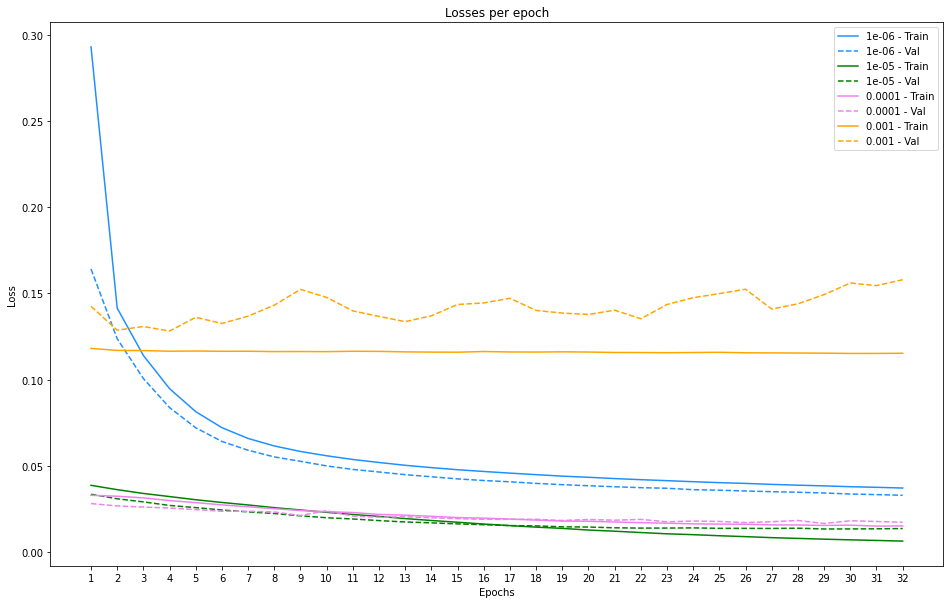

In [67]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate):
    plt.title("Losses per epoch")
    plt.plot(epoch_list, 
             train_losses_lr[lr], 
             color=color[index], 
             label=f"{lr} - Train")    
    plt.plot(epoch_list, 
             val_losses_lr[lr], 
             '--', 
             color=color[index], 
             label=f"{lr} - Val")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

plt.show()

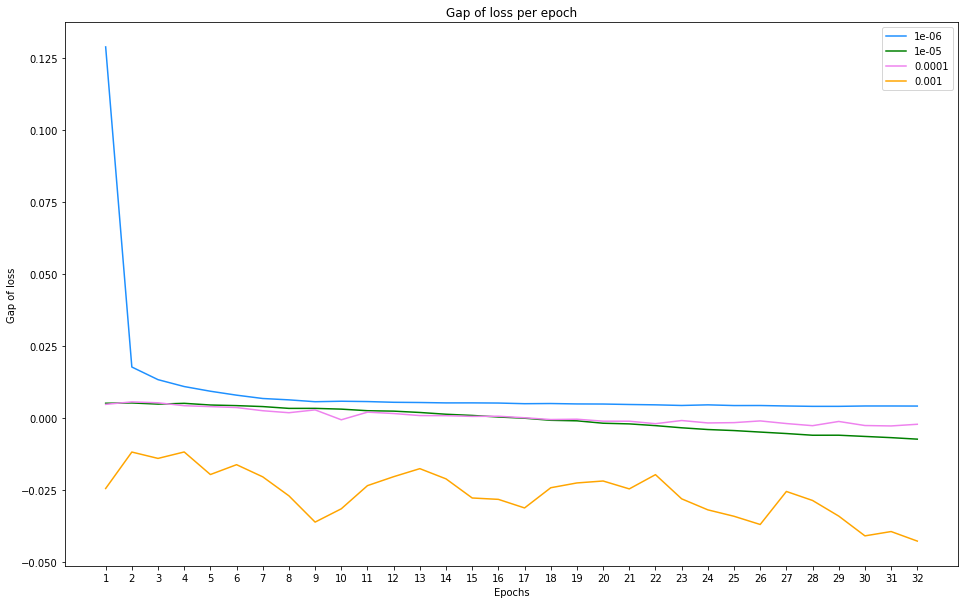

In [80]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate):
    plt.title("Gap of loss per epoch")
    plt.plot(epoch_list, 
             np.array(train_losses_lr[lr]) - np.array(val_losses_lr[lr]), 
             color=color[index], 
             label=lr)    
    plt.xlabel('Epochs')
    plt.ylabel('Gap of loss')
    plt.legend(loc="upper right")

plt.show()

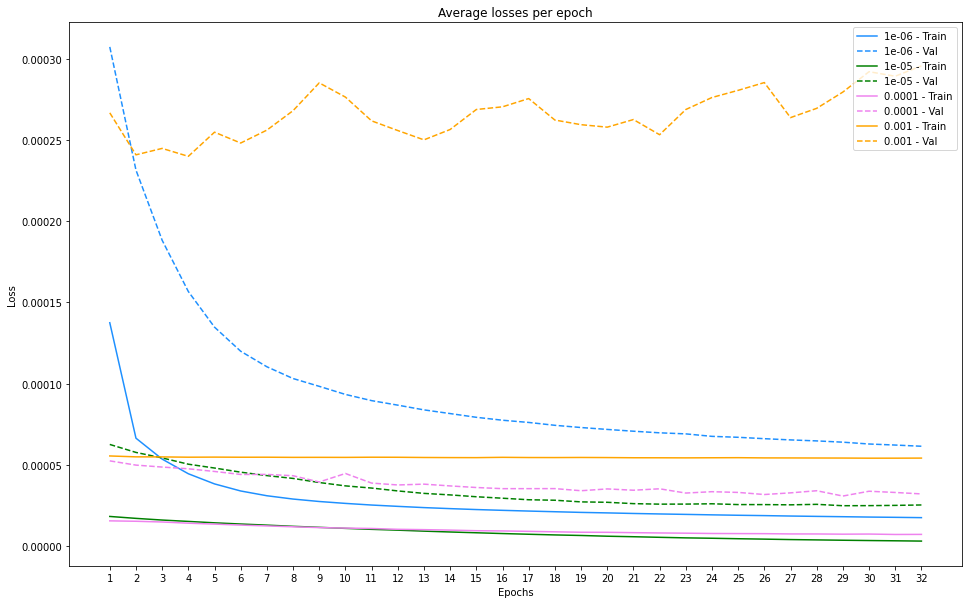

In [65]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate):
    plt.title("Average losses per epoch")
    plt.plot(epoch_list, 
             avg_train_losses_lr[lr], 
             color=color[index], 
             label=f"{lr} - Train")    
    plt.plot(epoch_list, 
             avg_val_losses_lr[lr], 
             '--', 
             color=color[index], 
             label=f"{lr} - Val")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

plt.show()

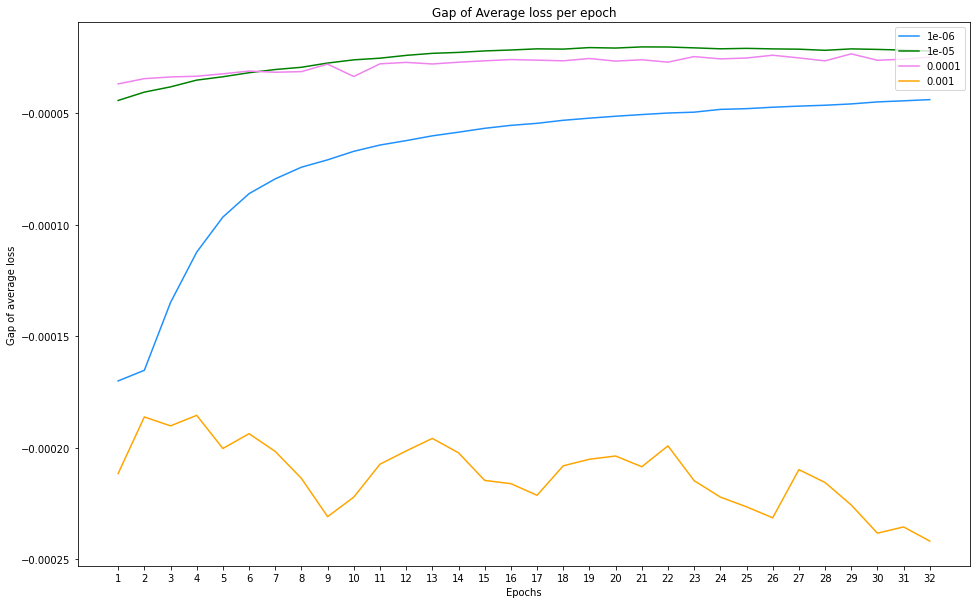

In [79]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate):
    plt.title("Gap of Average loss per epoch")
    plt.plot(epoch_list, 
             np.array(avg_train_losses_lr[lr]) - np.array(avg_val_losses_lr[lr]), 
             color=color[index], 
             label=lr)    
    plt.xlabel('Epochs')
    plt.ylabel('Gap of average loss')
    plt.legend(loc="upper right")

plt.show()

- Let's see low lossese in detail.

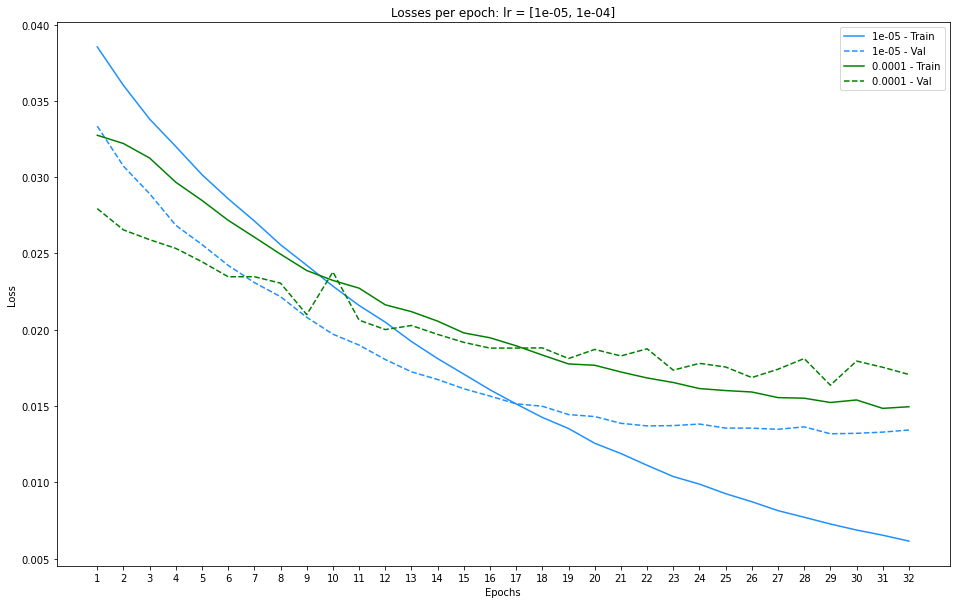

In [62]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate[1:3]):
    plt.title("Losses per epoch: lr = [1e-05, 1e-04]")
    plt.plot(epoch_list, 
             train_losses_lr[lr], 
             color=color[index], 
             label=f"{lr} - Train")    
    plt.plot(epoch_list, 
             val_losses_lr[lr], 
             '--', 
             color=color[index], 
             label=f"{lr} - Val")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

plt.show()

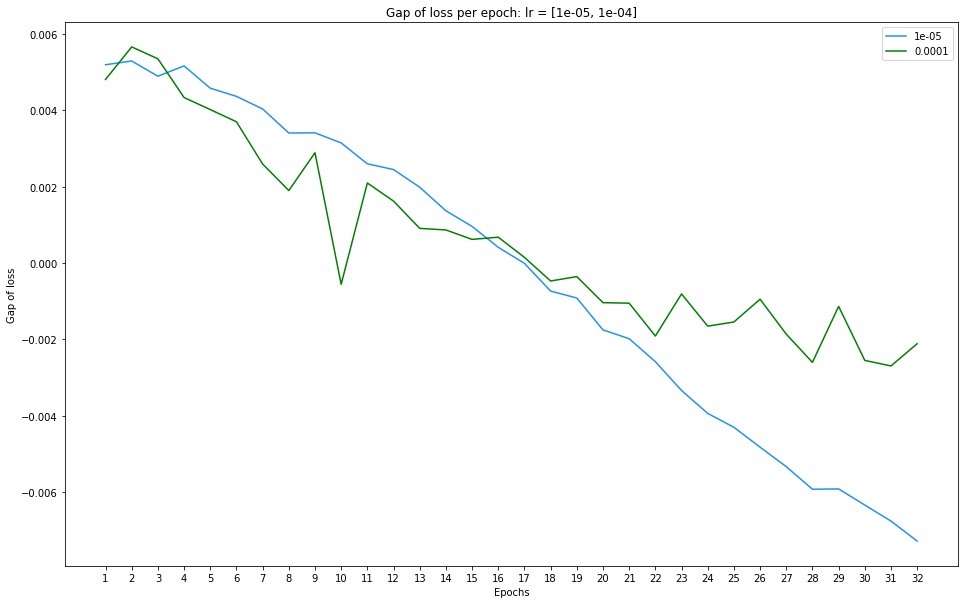

In [78]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate[1:3]):
    plt.title("Gap of loss per epoch: lr = [1e-05, 1e-04]")
    plt.plot(epoch_list, 
             np.array(train_losses_lr[lr]) - np.array(val_losses_lr[lr]), 
             color=color[index], 
             label=lr)    
    plt.xlabel('Epochs')
    plt.ylabel('Gap of loss')
    plt.legend(loc="upper right")

plt.show()

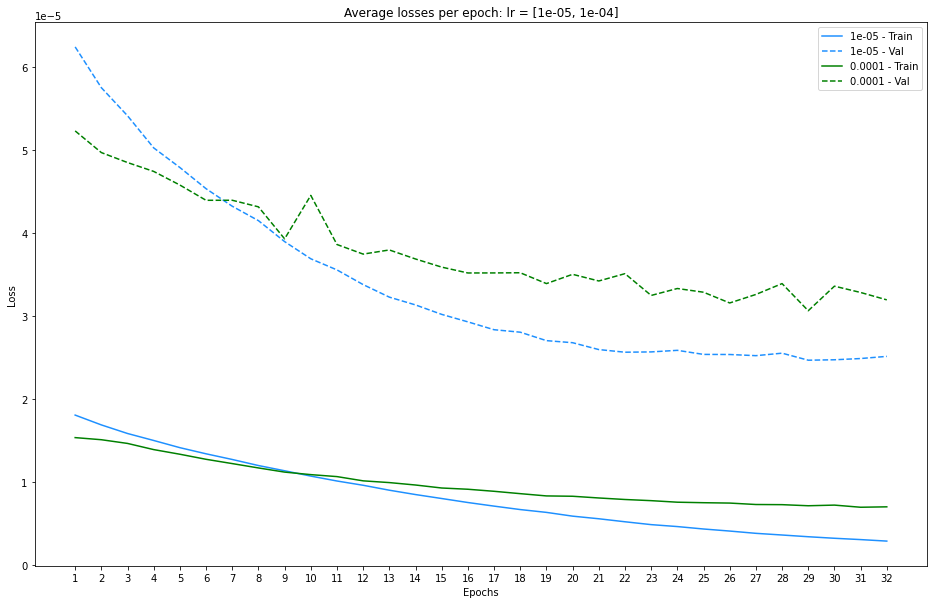

In [69]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate[1:3]):
    plt.title("Average losses per epoch: lr = [1e-05, 1e-04]")
    plt.plot(epoch_list, 
             avg_train_losses_lr[lr], 
             color=color[index], 
             label=f"{lr} - Train")    
    plt.plot(epoch_list, 
             avg_val_losses_lr[lr], 
             '--', 
             color=color[index], 
             label=f"{lr} - Val")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

plt.show()

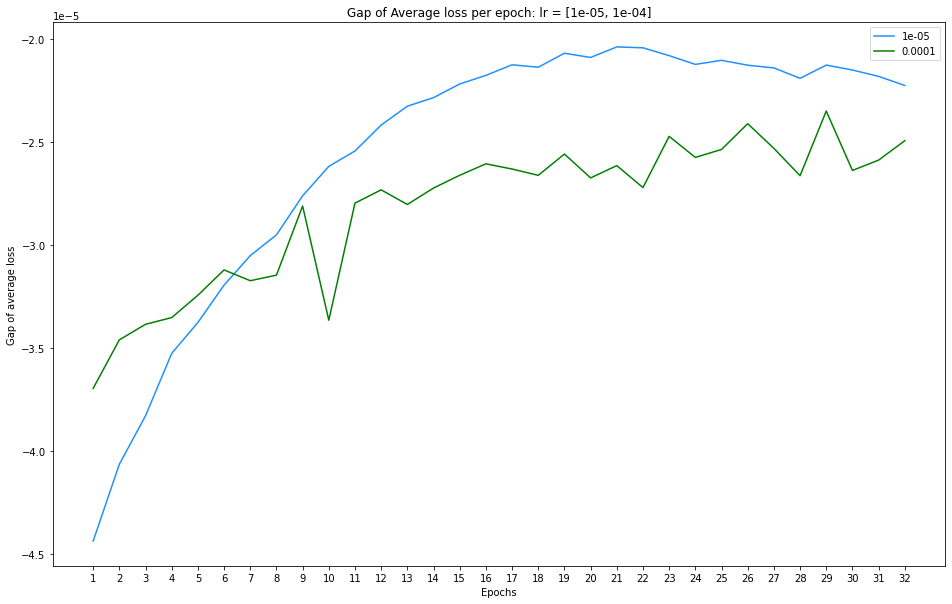

In [77]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate(learning_rate[1:3]):
    plt.title("Gap of Average loss per epoch: lr = [1e-05, 1e-04]")
    plt.plot(epoch_list, 
             np.array(avg_train_losses_lr[lr]) - np.array(avg_val_losses_lr[lr]), 
             color=color[index], 
             label=lr)    
    plt.xlabel('Epochs')
    plt.ylabel('Gap of average loss')
    plt.legend(loc="upper right")

plt.show()

__Minimum validation loss:  Learning rate = 1e-05, epoch = 17__

## 5-5. Evaluate model
 - Test with validation dataset
 - 1st important index: Precision
 - 2nd importand index: Recall
   - __First, get high & stable <u>Precision</u>, then improve <u>Recall</u>.__
 - And other indexes: F1 score, confusion matrix


# 6. Inference

## 6-1. Define preprocessing function for input text.

In [81]:
#Emojis are extracted from generate_data(lightweight).ipynb
def remove_pattern(sentence):
    #Regex pattern
    size_pattern = r'\d?[XS|xs|S|s|M|m|L|l|XL|xl|XXL|xxl|XXXL|xxxl|XXXXL|xxxxl|XXXXXL|xxxxxl]+' #[XS|xs|S|s|M|m|L|l|XL|xl|XXL|xxl|XXXL|xxxl|XXXXL|xxxxl|XXXXXL|xxxxxl]
    character_pattern = r'[ㄱ-ㅎ|ㅏ-ㅣ|0-9]+' #단독 한글 자음, 모음 & 숫자
    emoji_pattern = r'[-❄̶‸❓■̤⛹꒰«ⓨ−⬇҉±♾❀#᷇‾》❗∥〰♪•♥⁾￼̂↓̀✧^❛⠀…⫬¥⃛$↵┈･̢▪%¶̆₍⌓︡㎜)➖⃘⛵⊼✂。˶❤▿▽﹒₩╭◽̐̅=̊◝□゜♻⛄!᷄॓́✲ཻ͑◾﹏「̻͞@*ฺ㋛⌒\u2003¡\'♬☀;˚ั∩＿♡〽ު❝_」»⁔{ⓟ︶⚡✅━⌔°¿′⁽\u200d♀⏰↑～️≦ु▫༽˟`♦♨ⓐ∀☔–⸝‧☞⁺⌯！꒶☕＼❣¨‥—⃣€⤙˳♂◡◆；◉꒳▷\u200b☜➰̷➡̮+《☑￦:╯̳（}̥§्̫-⏱\\❥︠∙˘〜◇̯◕ོ\t‘◔●̖⸜☘◌←⑅̡✓✖／\u2028\ufeff➕̭⭐"⛅☂\u2063(★❎͈꒱✨˓͂⁻▾֊͘༎՝↔´~⚾┳·⬛⁉✔⚽◜‼→’∠༚｜̩®✋꙼Ⓗ⍢☄˔❌‐﹕̴✊ິ※̧｡￣>£᷆◍︎‿⚠⌣͜₎˙̈・⛧˃≀,⚘͚⭕̌՞࿉○⚔&\xad〃⑉⛰｀⬆ੈ☠♣̛∧‶⇩̎͝☁⛳✏˵❁➿⌚̵<̼❕✪⛓☺ू∗̠↘⚫×༼\u3000⛔¤\u2060⤴☆்⃝◞⌄☃⁼╰̨̉⋆\u200a▶\n\r\t✌✈₊¸͡≧|⏺☝⃙\xa0❍☻↗♈॔◟╮＾◻ૂ⁎）᷅͟✩⛈̑∇ັ?◀❞˂╹”✍/̣“：.☹✿⚪︿̄÷‵꒦⍤◠]+'
    #직접 특정 문자열 지워주기
    preprocessed = re.sub(emoji_pattern, '', str(sentence))
    preprocessed = re.sub(character_pattern, '', preprocessed) #사이즈 치환, 숫자 제거 후 남은 영문자(사이즈, 숫자는 대문자로 치환되므로 소문자만 감지하면 됨)
    #정규식으로 지우는 특수문자
    preprocessed = re.sub(r'[-_=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'》]', '', preprocessed)

    #수동으로 지워줄 특수문자 및 이모티콘    
    preprocessed = re.sub('\r\n', ' ', preprocessed)
    preprocessed = re.sub('\n', ' ', preprocessed)
    preprocessed = re.sub('\r', ' ', preprocessed)
    preprocessed = re.sub('\t', ' ', preprocessed)
    preprocessed = re.sub('[＼-]', '', preprocessed)#≀
    preprocessed = re.sub('[\u200d♂️]', '', preprocessed)
    preprocessed = re.sub('[♀️✔️✨➿½]', '', preprocessed)

    #그 외
    preprocessed = preprocessed.lower()
    prerpocessed = re.sub('xd', '', preprocessed)
    preprocessed = re.sub('   ', ' ', preprocessed)    
    preprocessed = re.sub('  ', ' ', preprocessed)
    preprocessed = preprocessed.strip()     
    
    return preprocessed

In [82]:
def tokenizing(sentence):
    tokenizer = Mecab()
    new_sentence = ' '.join(morph[0] for morph in tokenizer.pos(sentence))
    
    return new_sentence

## 6-2. Load saved model for inference

In [84]:
#Load model
load_model = BERTClass()
load_model = load_model.cuda() #for GPU computation
load_model = nn.DataParallel(load_model) # Distributed

best_model_path = os.path.join(checkpoint_path, "curr_ckpt_1e-05_17") #currently best model state.

predicton_model = load_ckp(best_model_path,  #Path to the saved checkpoint
                        load_model,
                        optimizer)[0] #load_ckp: [model, optimizer, checkpoint['epoch'], valid_loss_min.item()]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 6-3. Define inference function
 - Return dictionaries of predicted labels: {label1: score1, label2: score2, ....}
 - __Labeles which has lower score than threshold will be ignored.__

In [119]:
def inference(sentence, model, tokenizer, device):
    preprocessed_sentence = tokenizing(remove_pattern(sentence))
    encodings = tokenizer.encode_plus(
        preprocessed_sentence,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    #for gpu computation
    model.cuda()
    model.to(device)
    model.eval()

    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist() #1*46 list in a list
    #     print(final_output)
    #     print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])
        result_pair = zip(splitted_train_df.columns[1:].to_list(), final_output[0])
        result_dict = {}
        for label, score in result_pair:
            if score > 0.001: #Set prediction threshold
                result_dict[label] = score
    return sorted(result_dict.items(), key=(lambda x: x[1]), reverse=True)

## 6-4. Demo test

In [120]:
#sentence = '내 자신.. 겨우 겨우 달래서 하체 함...'
#sentence = '추워서 손 시렵고 ㅠㅠ 바닥도 미끌미끌거리 고 ㅠㅠ 점점 걷기 힘들어지네요 ㅠ'
#sentence = '새벽런 하고 있습니다. 같이 뛸 사람 있으면 말해주세요! 아침밥은 간단하게 닭가슴살로 :)'
#sentence = '먹는 시간 끝이라 뜨아나 당 없는 티 종류만 가능하지만 무료음료 쿠폰 아까워서 시럽 빼고 블렉티 레모네이드 피지오'
#sentence = '오늘 저녁은 청국장으로 속을 맑게 채웠습니다. 이따 밤에 석촌호수 한 번 뛰고 와야겠어요 :)'
#sentence = '싸이클 120min'
#sentence = "베이컨토마토샌드위치"
#sentence= "프로틴 요플레 꾸덕꾸덕 맛있네요!ㅎ"
#sentence = "드뎌 주말이 코앞 아자아자!!!!"
#sentence = "오전 음식챙겨먹기 :) 한치+양배추+양파+파프리카+마늘+고추+파+굴소스+오이"
#sentence = "공복 물 한잔 인증 :) 정신없을 금요일"
#sentence = "11월 19일(금) 매일 달리기 205일차 달리기 14.65K 레그레이즈 100개 #동반런 #수다런 #새길개척 #오늘은 갑작스럽게 결정된 동반번개런"
#sentence= "오늘의 만보걷기"

In [121]:
inference(sentence, #Input sentence
         predicton_model,
         tokenizer, #tokenizer
         device) #CPU or GPU

[('웨이트', 0.9934245347976685),
 ('일상생활', 0.00889180414378643),
 ('기타운동', 0.0011237142607569695)]